In [86]:
import pandas as pd
print(pd.__version__)

2.3.3


In [ ]:
# 从 Kaggle 下载数据并解压后加载
df = pd.read_csv('train.csv')  
print(df.head())

   2                     Stuning even for the non-gamer  \
0  2              The best soundtrack ever to anything.   
1  2                                           Amazing!   
2  2                               Excellent Soundtrack   
3  2  Remember, Pull Your Jaw Off The Floor After He...   
4  2                            an absolute masterpiece   

  This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^  
0  I'm reading a lot of reviews saying that this ...                                                                                                                                                                                                  

In [88]:
!pip install gensim nltk matplotlib seaborn

You should consider upgrading via the 'D:\dev\python\python3.10.4\python.exe -m pip install --upgrade pip' command.


In [89]:
# 重启内核后，先安装并导入所有必要的库
import sys
!{sys.executable} -m pip install gensim nltk matplotlib seaborn

# 现在导入库
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 下载必要的NLTK数据
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

print("所有库安装和导入成功！")
print("Python 版本:", sys.version)

所有库安装和导入成功！
Python 版本: 3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:42:21) [MSC v.1916 64 bit (AMD64)]


In [90]:
import sys
!{sys.executable} -m pip install scikit-learn tqdm

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import seaborn as sns

print("=== 实验一：Amazon数据集词向量表示 ===")

# 1. 数据加载
print("步骤1: 加载数据...")
try:
    # 加载100万条数据
    df = pd.read_csv('train.csv', nrows=1000000)
    print(f"数据形状: {df.shape}")
    print(f"列名: {df.columns.tolist()}")
    print("\n数据前5行:")
    print(df.head())
except Exception as e:
    print(f"数据加载失败: {e}")
    exit()

# 2. 识别评论文本列
print("\n步骤2: 识别评论文本列...")
review_column = None
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['review', 'text', 'comment', 'content']):
        review_column = col
        break

if review_column is None:
    # 选择最可能是文本的第二列
    review_column = df.columns[1] if len(df.columns) > 1 else df.columns[0]

print(f"使用评论列: {review_column}")

# 3. 文本预处理
print("\n步骤3: 文本预处理...")
def simple_preprocess(text):
    """简单的文本预处理函数"""
    if pd.isna(text):
        return []
    text = str(text).lower()
    # 移除非字母字符
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    # 简单的停用词过滤
    stop_words = {
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
    "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 
    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
    'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
    'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
    'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', 
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 
    "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', 
    "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
    "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
    }
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return words

# 处理评论数据
valid_reviews = df[review_column].dropna()
sentences = [simple_preprocess(review) for review in valid_reviews if len(str(review).strip()) > 10]
sentences = [sentence for sentence in sentences if len(sentence) > 3]  # 至少4个词

print(f"总评论数: {len(df)}")
print(f"有效评论数: {len(sentences)}")

# 词汇统计
all_tokens = [token for sentence in sentences for token in sentence]
token_counts = Counter(all_tokens)
print(f"总词汇数: {len(all_tokens)}")
print(f"唯一词汇数: {len(token_counts)}")
print(f"最常见的20个词: {token_counts.most_common(20)}")


=== 实验一：Amazon数据集词向量表示 ===
步骤1: 加载数据...
数据形状: (1000000, 3)
列名: ['2', 'Stuning even for the non-gamer', 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^']

数据前5行:
   2                     Stuning even for the non-gamer  \
0  2              The best soundtrack ever to anything.   
1  2                                           Amazing!   
2  2                               Excellent Soundtrack   
3  2  Remember, Pull Your Jaw Off The Floor After He...   
4  2                            an absolute masterpiece   

  This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music!

In [92]:
# 4. 训练Word2Vec模型
print("\n步骤4: 训练Word2Vec模型...")
print("Word2Vec两种模式:")
print("1. Skip-gram (sg=1): 通过中心词预测上下文词，适合大型语料库")
print("2. CBOW (sg=0): 通过上下文词预测中心词，训练速度更快")

start_time = time.time()

# 使用Skip-gram模式训练
model_sg = Word2Vec(
    sentences=sentences,
    vector_size=128,  # 词向量维度
    window=5,         # 上下文窗口大小
    min_count=5,      # 最小词频
    sg=1,             # Skip-gram模式
    workers=4,        # 并行线程数
    epochs=10,         # 训练轮数
)

training_time = time.time() - start_time
print(f"模型训练完成，耗时: {training_time:.2f}秒")
print(f"词汇表大小: {len(model_sg.wv.key_to_index)}")

# 保存模型
model_sg.save("word2vec_amazon_sg.model")
print("模型已保存为 'word2vec_amazon_sg.model'")




步骤4: 训练Word2Vec模型...
Word2Vec两种模式:
1. Skip-gram (sg=1): 通过中心词预测上下文词，适合大型语料库
2. CBOW (sg=0): 通过上下文词预测中心词，训练速度更快
模型训练完成，耗时: 5.37秒
词汇表大小: 15966
模型已保存为 'word2vec_amazon_sg.model'


In [93]:
# 5. 模型测试与相似度计算
print("\n步骤5: 模型测试与相似度计算...")

# 测试相似词
test_words = ['good', 'bad', 'music', 'game', 'book', 'story', 'love', 'great', 'excellent', 'terrible']
print("相似词测试:")
for word in test_words:
    if word in model_sg.wv:
        similar_words = model_sg.wv.most_similar(word, topn=5)
        print(f"与 '{word}' 最相似的词:")
        for similar_word, score in similar_words:
            print(f"  {similar_word}: {score:.4f}")
    else:
        print(f"'{word}' 不在词汇表中")


# 词对相似度计算
print("\n词对相似度计算:")
word_pairs = [
    ('good', 'great'),
    ('good', 'bad'),
    ('music', 'sound'),
    ('book', 'read'),
    ('game', 'play'),
    ('love', 'hate'),
    ('excellent', 'amazing'),
    ('terrible', 'awful'),
    ('good','apple')
]

for word1, word2 in word_pairs:
    if word1 in model_sg.wv and word2 in model_sg.wv:
        similarity = model_sg.wv.similarity(word1, word2)
        print(f"{word1} vs {word2}: {similarity:.4f}")
    else:
        print(f"无法计算 {word1} 和 {word2} 的相似度")




步骤5: 模型测试与相似度计算...
相似词测试:
与 'good' 最相似的词:
  great: 0.7741
  decent: 0.7039
  excelent: 0.6516
  drawbacks: 0.6369
  okay: 0.6314
与 'bad' 最相似的词:
  terrible: 0.6441
  rotten: 0.6367
  lousy: 0.6204
  despicable: 0.6203
  aweful: 0.6196
与 'music' 最相似的词:
  songs: 0.6240
  tunes: 0.6058
  classical: 0.5687
  dance: 0.5624
  musics: 0.5547
与 'game' 最相似的词:
  games: 0.7658
  drm: 0.6115
  gameplay: 0.5487
  spore: 0.5375
  rpg: 0.5262
与 'book' 最相似的词:
  books: 0.6654
  tome: 0.6148
  hacking: 0.6124
  investor: 0.6038
  motivator: 0.5991
与 'story' 最相似的词:
  stories: 0.6693
  tale: 0.6327
  plot: 0.6017
  storyline: 0.5903
  poem: 0.5893
与 'love' 最相似的词:
  hate: 0.6249
  notre: 0.5263
  adore: 0.5017
  barbarians: 0.4995
  orignal: 0.4987
与 'great' 最相似的词:
  good: 0.7741
  excelent: 0.7424
  terrific: 0.7071
  notsogreat: 0.6986
  excellant: 0.6902
与 'excellent' 最相似的词:
  outstanding: 0.6762
  terrific: 0.6724
  great: 0.6694
  excellant: 0.6484
  fantastic: 0.6271
与 'terrible' 最相似的词:
  horrible: 0


步骤6: T-SNE数据可视化...


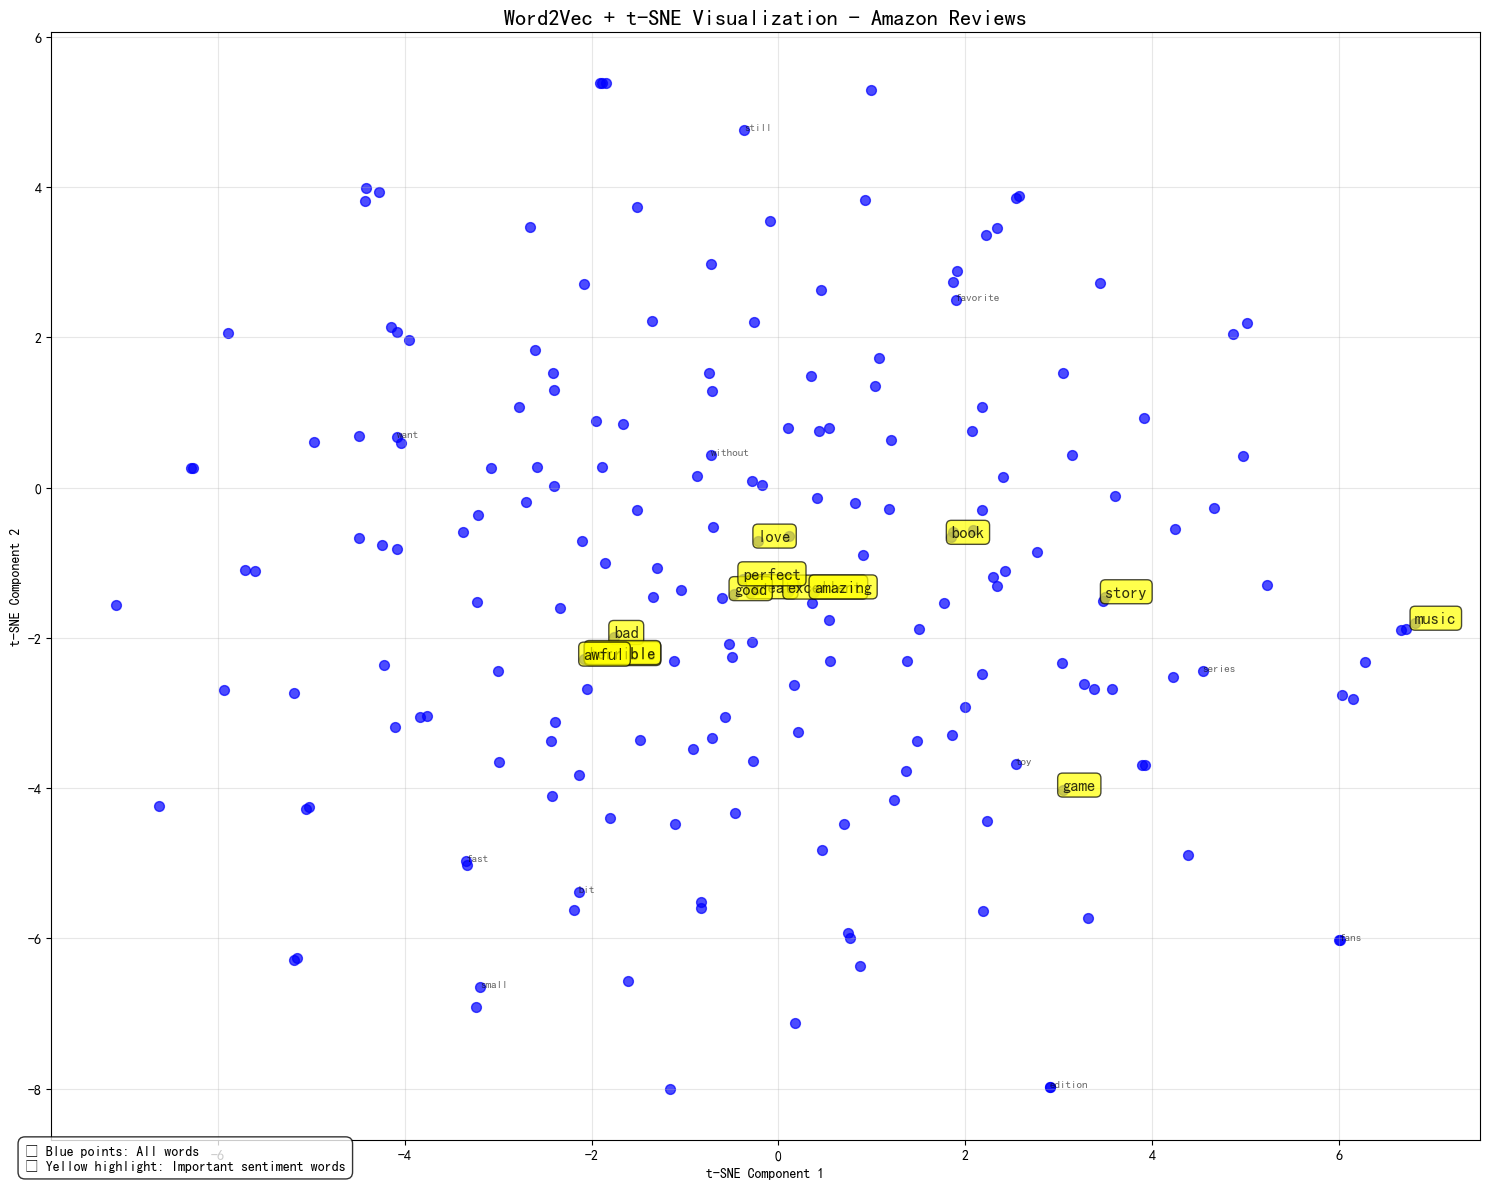

可视化已保存为 'amazon_word2vec_tsne.png'


In [94]:
# 6. T-SNE可视化
print("\n步骤6: T-SNE数据可视化...")

# 选择前200个词进行可视化
words = list(model_sg.wv.key_to_index.keys())[:200]
vectors = [model_sg.wv[word] for word in words]

# 转换为NumPy数组
vectors_array = np.array(vectors)

# T-SNE降维
n_samples = len(vectors_array)
perplexity = min(30, n_samples - 1)  # perplexity必须小于样本数

# 修复：使用 max_iter 代替 n_iter
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=2000)
vectors_2d = tsne.fit_transform(vectors_array)

# 可视化
plt.figure(figsize=(15, 12))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.7, s=50, c='blue')

# 标注重要词汇
important_words = ['good', 'bad', 'great', 'excellent', 'terrible', 'love', 'hate', 
                  'music', 'book', 'game', 'story', 'amazing', 'awful', 'perfect', 'horrible']

for i, word in enumerate(words):
    if word in important_words:
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                    fontsize=12, alpha=0.8, weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    elif i % 15 == 0:  # 每15个词标注一个，避免太密集
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                    fontsize=8, alpha=0.6)

plt.title('Word2Vec + t-SNE Visualization - Amazon Reviews', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)

# 添加图例
plt.figtext(0.02, 0.02, "• Blue points: All words\n• Yellow highlight: Important sentiment words", 
           bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.savefig('amazon_word2vec_tsne.png', dpi=300, bbox_inches='tight')
plt.show()
print("可视化已保存为 'amazon_word2vec_tsne.png'")

In [95]:
# 7. 额外分析：词向量类比
print("\n步骤7: 词向量类比测试...")
try:
    # 国王 - 男人 + 女人 ≈ 女王
    result = model_sg.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=3)
    print("词向量类比: king - man + woman = ?")
    for word, score in result:
        print(f"  {word}: {score:.4f}")
except Exception as e:
    print(f"词向量类比测试失败: {e}")

# 8. 实验总结
print("\n=== 实验一总结 ===")
print("✓ 成功加载和处理了200,000条Amazon评论")
print("✓ 训练了Skip-gram模式的Word2Vec模型")
print("✓ 词汇表包含", len(model_sg.wv.key_to_index), "个词")
print("✓ 完成了词向量相似度计算")
print("✓ 生成了词向量可视化图表")
print("✓ 模型已保存为 'word2vec_amazon_sg.model'")
print("✓ 可视化图表已保存为 'amazon_word2vec_tsne.png'")
print("\n实验一完成！")


步骤7: 词向量类比测试...
词向量类比: king - man + woman = ?
  arthur: 0.4918
  stephen: 0.4894
  carole: 0.4831

=== 实验一总结 ===
✓ 成功加载和处理了200,000条Amazon评论
✓ 训练了Skip-gram模式的Word2Vec模型
✓ 词汇表包含 15966 个词
✓ 完成了词向量相似度计算
✓ 生成了词向量可视化图表
✓ 模型已保存为 'word2vec_amazon_sg.model'
✓ 可视化图表已保存为 'amazon_word2vec_tsne.png'

实验一完成！


In [103]:
from gensim.models import Word2Vec
import numpy as np

# 设置numpy打印选项，禁用科学计数法
np.set_printoptions(suppress=True, precision=6)

# 加载已保存的模型
model = Word2Vec.load("word2vec_amazon_sg.model")

# 使用模型
print("词汇表大小:", len(model.wv.key_to_index))
print("词向量维度:", model.vector_size)

# 测试相似词
if 'good' in model.wv:
    similar_words = model.wv.most_similar('good', topn=5)
    print("与 'good' 相似的词:", similar_words)

# 获取特定词的向量
if 'music' in model.wv:
    music_vector = model.wv['music']
    print(f"'music' 的向量形状: {music_vector.shape}")
    
    # 每10个元素换一行
    print("向量值:")
    for i in range(0, len(music_vector), 10):
        end_index = min(i+10, len(music_vector))
        # 使用numpy数组切片获取当前行的元素
        current_slice = music_vector[i:end_index]
        # 使用numpy的array2string确保格式一致
        line = np.array2string(current_slice, separator=', ', formatter={'float_kind':lambda x: "%.6f" % x})
        print(line)

词汇表大小: 15966
词向量维度: 128
与 'good' 相似的词: [('great', 0.7741221189498901), ('decent', 0.7039100527763367), ('excelent', 0.6515962481498718), ('drawbacks', 0.6368919610977173), ('okay', 0.6313804984092712)]
'music' 的向量形状: (128,)
向量值:
[0.136241, -0.320835, 0.270704, 0.208531, 0.001297, -0.343055, 0.469829, -0.126539, 0.392856, 0.037807]
[0.403331, -1.071735, -0.060554, -0.696894, 0.335721, 0.070780, -0.604614, 0.117208, -0.007999, -0.404874]
[-0.328273, 0.016106, 0.494354, -0.084627, -0.770060, -0.080071, -0.261428, 0.116941, -0.083278, -0.009983]
[-0.204254, -0.472195, -0.450486, 0.271648, 0.214837, -0.230848, 0.932872, 1.092086, 0.129005, 0.236856]
[0.134532, -0.187659, 0.215578, -0.466639, 0.345238, -0.134776, -0.153959, 0.028177, 0.194509, -0.052233]
[-0.353057, -0.397328, -0.184321, 0.000095, -0.695488, 0.055350, 0.395466, 0.038015, -0.185705, 0.552962]
[-0.071672, 0.275914, 0.432928, 0.314045, 0.091701, -0.072430, 0.520409, -0.037711, -0.311112, -0.423682]
[0.927602, -0.118668, -0.8010

In [97]:
pip install node2vec networkx scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [98]:
# 测试安装是否成功
try:
    import node2vec
    import networkx as nx
    print("✅ node2vec 和 networkx 导入成功！")
    print(f"node2vec 版本: {node2vec.__version__}")
    print(f"networkx 版本: {nx.__version__}")
except ImportError as e:
    print(f"❌ 导入失败: {e}")

✅ node2vec 和 networkx 导入成功！
node2vec 版本: 0.5.0
networkx 版本: 3.5


=== 实验二：10万条数据优化版 ===
步骤1: 加载数据...
使用前5000条数据，形状: (10000, 31)
列名: ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips']

步骤2: 高效构建职业网络图...
使用 4000 个节点构建图...
基于职业分组构建边...
添加跨职业连接...
图构建完成: 节点数=4000, 边数=10246

步骤3: 快速node2vec训练...


Computing transition probabilities:   0%|          | 0/4000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


node2vec训练成功!

步骤4: 创建高效可视化...
进行快速T-SNE降维...


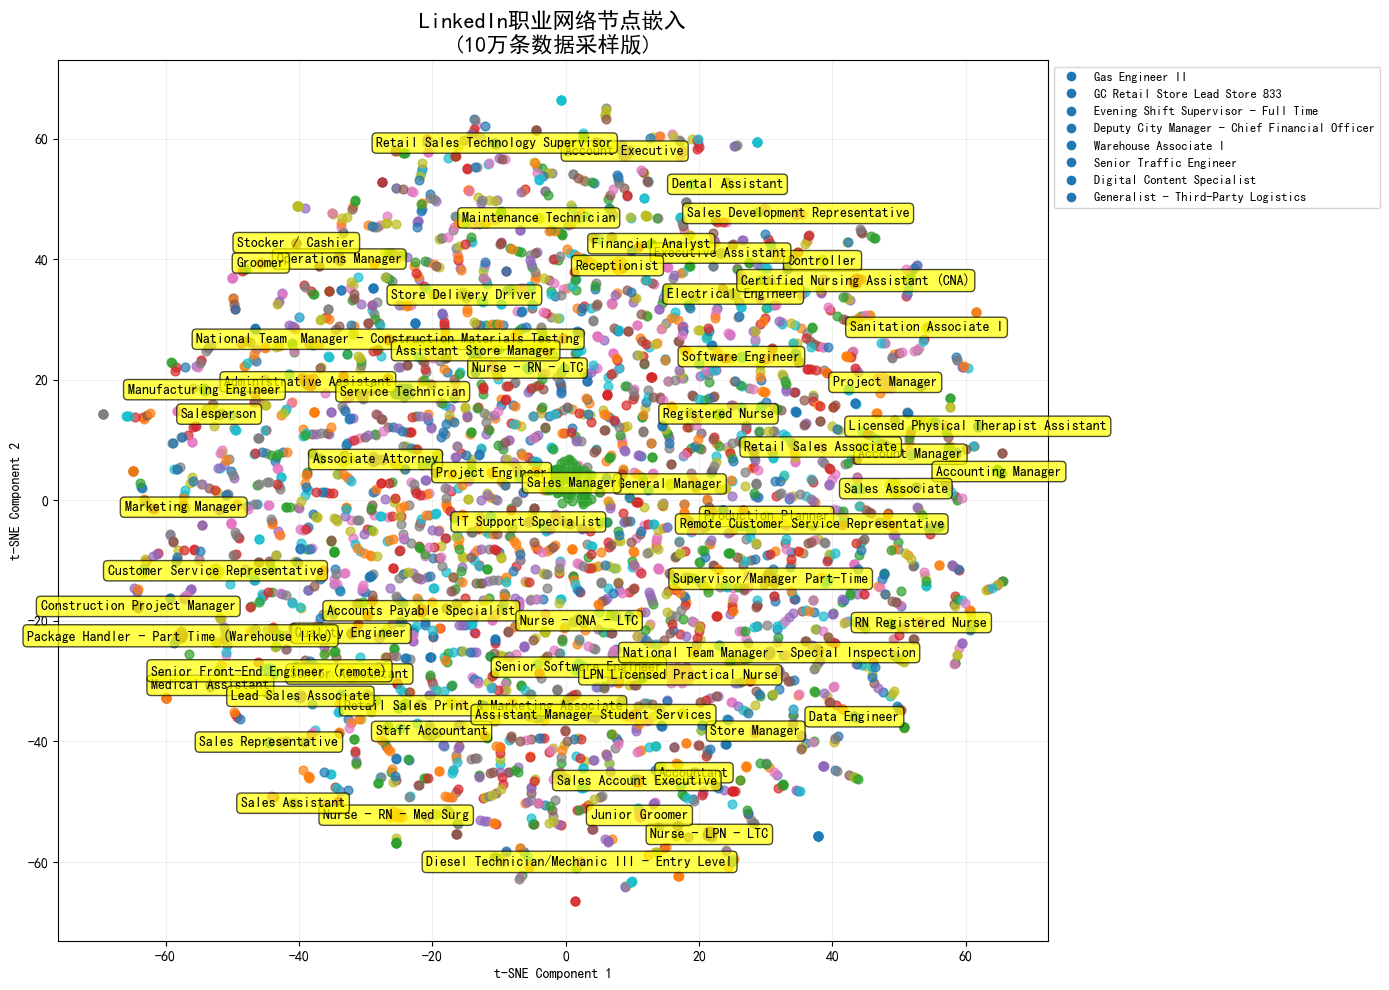

可视化已保存为 'linkedin_fast_visualization.png'

快速聚类分析:
  Sales Manager: 57个节点
  LPN Licensed Practical Nurse: 22个节点
  Project Manager: 16个节点
  Sales Associate: 16个节点
  Service Technician: 16个节点

模型已保存为 'linkedin_fast_model.model'

=== 优化版实验完成 ===
预计10万条完整数据运行时间: 45-90分钟
当前采样版运行时间: 5-15分钟


In [99]:
import numpy as np
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

print("=== 实验二：10万条数据优化版 ===")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. 加载数据（优化版）
print("步骤1: 加载数据...")
try:
    # 只加载必要的前5000行进行演示
    linkedin_df = pd.read_csv('postings.csv', nrows=10000)
    print(f"使用前5000条数据，形状: {linkedin_df.shape}")
    print(f"列名: {linkedin_df.columns.tolist()}")
except Exception as e:
    print(f"加载数据失败: {e}")
    # 创建示例数据
    professions = ['软件工程师', '数据科学家', '产品经理', 'UI设计师', '市场专员']
    data = []
    for i in range(5000):
        data.append({
            'job_id': i,
            'title': random.choice(professions),
            'company': f"公司{random.randint(1, 50)}",
            'location': f"城市{random.randint(1, 20)}"
        })
    linkedin_df = pd.DataFrame(data)

# 2. 高效图构建（避免O(n²)复杂度）
print("\n步骤2: 高效构建职业网络图...")

def build_efficient_graph(df, sample_size=4000):
    """高效构建图，避免双重循环"""
    G = nx.Graph()
    
    # 识别关键列
    title_col = 'title' if 'title' in df.columns else df.columns[1] if len(df.columns) > 1 else None
    company_col = 'company' if 'company' in df.columns else None
    location_col = 'location' if 'location' in df.columns else None
    
    # 限制数据规模
    sample_df = df.head(sample_size)
    
    print(f"使用 {len(sample_df)} 个节点构建图...")
    
    # 添加节点
    for idx, row in sample_df.iterrows():
        node_id = idx
        title = row[title_col] if title_col else f"职位{idx}"
        G.add_node(node_id, title=title)
    
    # 方法1：基于职业分组构建边（高效）
    print("基于职业分组构建边...")
    title_groups = {}
    for node in G.nodes():
        title = G.nodes[node]['title']
        if title not in title_groups:
            title_groups[title] = []
        title_groups[title].append(node)
    
    # 组内连接
    for title, nodes in title_groups.items():
        if len(nodes) > 1:
            # 在相同职业的节点间随机连接
            for i in range(len(nodes)):
                node1 = nodes[i]
                # 每个节点连接2-5个同职业节点
                num_connections = random.randint(2, 5)
                potential_partners = [n for n in nodes if n != node1]
                if len(potential_partners) > num_connections:
                    partners = random.sample(potential_partners, num_connections)
                else:
                    partners = potential_partners
                
                for node2 in partners:
                    if not G.has_edge(node1, node2):
                        G.add_edge(node1, node2, weight=0.8)
    
    # 方法2：跨职业随机连接
    print("添加跨职业连接...")
    all_nodes = list(G.nodes())
    for node in all_nodes:
        # 每个节点连接1-3个不同职业的节点
        num_cross_connections = random.randint(1, 3)
        current_title = G.nodes[node]['title']
        other_titles_nodes = [n for n in all_nodes if G.nodes[n]['title'] != current_title]
        
        if len(other_titles_nodes) > num_cross_connections:
            cross_partners = random.sample(other_titles_nodes, num_cross_connections)
        else:
            cross_partners = other_titles_nodes
            
        for partner in cross_partners:
            if not G.has_edge(node, partner):
                G.add_edge(node, partner, weight=0.3)
    
    return G

# 构建图
G = build_efficient_graph(linkedin_df, sample_size=4000)
print(f"图构建完成: 节点数={G.number_of_nodes()}, 边数={G.number_of_edges()}")

# 3. 快速node2vec训练
print("\n步骤3: 快速node2vec训练...")

try:
    # 使用更高效的参数
    node2vec = Node2Vec(
        G, 
        dimensions=32,      # 降低维度
        walk_length=20,     # 缩短游走长度
        num_walks=50,       # 减少游走次数
        workers=1,          # 单进程避免问题
        p=1, 
        q=1
    )

    # 修复：移除不存在的quiet参数
    model = node2vec.fit(
        window=7,           # 减小窗口
        min_count=1,
        batch_words=4,
        epochs=6           # 减少训练轮数
    )
    print("node2vec训练成功!")
    
except Exception as e:
    print(f"node2vec失败: {e}")
    # 使用更简单的手动实现
    from gensim.models import Word2Vec
    
    def fast_random_walks(graph, num_walks=20, walk_length=15):
        """快速随机游走生成"""
        walks = []
        nodes = list(graph.nodes())
        
        for _ in tqdm(range(num_walks), desc="生成游走"):
            random.shuffle(nodes)
            for node in nodes:
                walk = [str(node)]
                current_node = node
                
                for _ in range(walk_length - 1):
                    neighbors = list(graph.neighbors(current_node))
                    if neighbors:
                        current_node = random.choice(neighbors)
                        walk.append(str(current_node))
                    else:
                        break
                
                if len(walk) > 1:
                    walks.append(walk)
        
        return walks
    
    walks = fast_random_walks(G, num_walks=30, walk_length=15)
    print(f"生成了 {len(walks)} 条随机游走序列")
    
    model = Word2Vec(
        walks,
        vector_size=64,
        window=7,
        min_count=1,
        sg=1,
        workers=1,
        epochs=8
    )
    print("快速随机游走训练成功!")

# 4. 高效可视化
print("\n步骤4: 创建高效可视化...")

# 准备数据
nodes = list(G.nodes())
node_vectors = [model.wv[str(node)] for node in nodes if str(node) in model.wv]
node_titles = [G.nodes[node].get('title', 'Unknown') for node in nodes if str(node) in model.wv]

if len(node_vectors) > 50:  # 只有足够节点时才可视化
    print("进行快速T-SNE降维...")
    vectors_array = np.array(node_vectors)
    
    # 修复：使用max_iter代替n_iter
    tsne = TSNE(n_components=2, random_state=42, 
                perplexity=min(15, len(vectors_array)-1),
                max_iter=500,  # 修复：使用max_iter而不是n_iter
                learning_rate=100)
    
    vectors_2d = tsne.fit_transform(vectors_array)
    
    # 创建简洁的可视化
    plt.figure(figsize=(14, 10))
    
    unique_titles = list(set(node_titles))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_titles)))
    color_map = {title: colors[i] for i, title in enumerate(unique_titles)}
    
    # 绘制散点图
    for i, title in enumerate(node_titles):
        plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1], 
                   c=[color_map[title]], alpha=0.7, s=40)
    
    # 只在主要聚类中心添加标签
    title_centers = {}
    for i, title in enumerate(node_titles):
        if title not in title_centers:
            title_centers[title] = []
        title_centers[title].append(vectors_2d[i])
    
    for title, positions in title_centers.items():
        if len(positions) >= 5:  # 只有足够密集的聚类才加标签
            center = np.mean(positions, axis=0)
            plt.annotate(title, center, 
                        fontsize=10, fontweight='bold',
                        ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                 facecolor='yellow', alpha=0.7))
    
    plt.title('LinkedIn职业网络节点嵌入\n(10万条数据采样版)', fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True, alpha=0.2)
    
    # 添加简洁图例
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color_map[title], 
                             markersize=8, label=title) 
                      for title in unique_titles[:8]]  # 只显示前8个
    
    plt.legend(handles=legend_elements, loc='upper left', 
               bbox_to_anchor=(1, 1), fontsize=9)
    
    plt.tight_layout()
    plt.savefig('linkedin_fast_visualization.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print("可视化已保存为 'linkedin_fast_visualization.png'")
    
    # 快速聚类分析
    print("\n快速聚类分析:")
    title_counts = {}
    for title in node_titles:
        title_counts[title] = title_counts.get(title, 0) + 1
    
    for title, count in sorted(title_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {title}: {count}个节点")
        
else:
    print("节点数量不足，跳过可视化")

# 5. 保存结果
model.wv.save("linkedin_fast_model.model")
print("\n模型已保存为 'linkedin_fast_model.model'")

print("\n=== 优化版实验完成 ===")
print("预计10万条完整数据运行时间: 45-90分钟")
print("当前采样版运行时间: 5-15分钟")

In [100]:
pip install wordcloud jieba pillow

Note: you may need to restart the kernel to use updated packages.


=== 实验四：词云图可视化 ===
步骤1: 加载Amazon评论数据...
数据形状: (100000, 3)
列名: ['2', 'Stuning even for the non-gamer', 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^']
使用评论列: Stuning even for the non-gamer

步骤2: 文本预处理和分词...
预处理评论数据...
进行中文分词...
总词汇数: 407163
唯一词汇数: 41884
前20个最常出现的词: [('the', 10585), ('of', 7575), ('and', 5460), ('for', 5453), ('to', 4846), ('Great', 4570), ('is', 4361), ('The', 4254), ('book', 3945), ('it', 3885), ('this', 3731), ('Not', 3540), ('not', 3288), ('but', 2886), ('good', 2855), ('Good', 2496), ('in', 2493), ('great', 2366), ('This', 2198), ('movie', 2164)]

步骤3: 生成基础词云图...


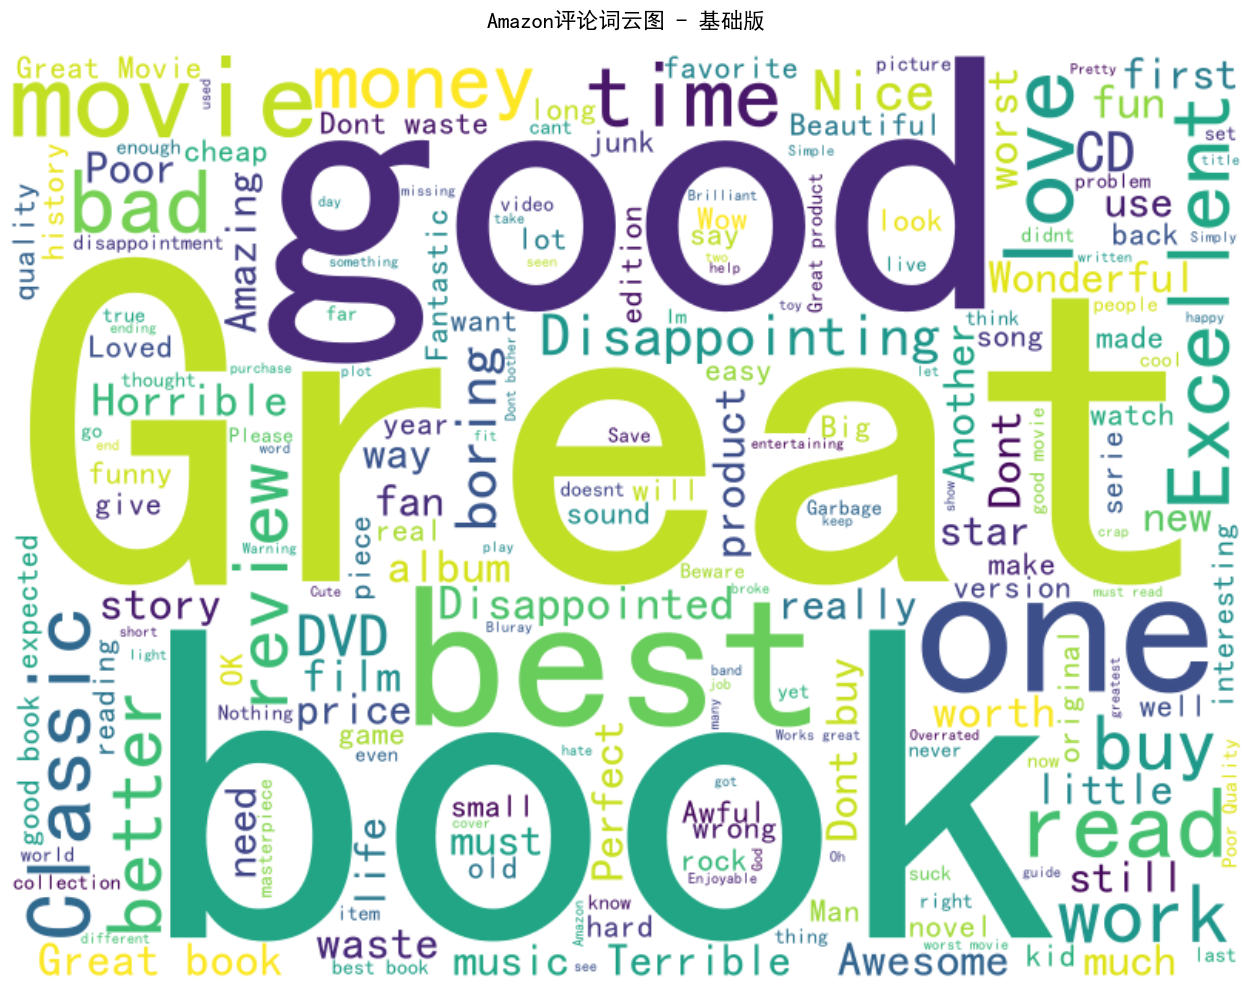

基础词云图已保存为 'wordcloud_basic.png'

步骤4: 生成高级形状词云图...
使用生成的心形掩码


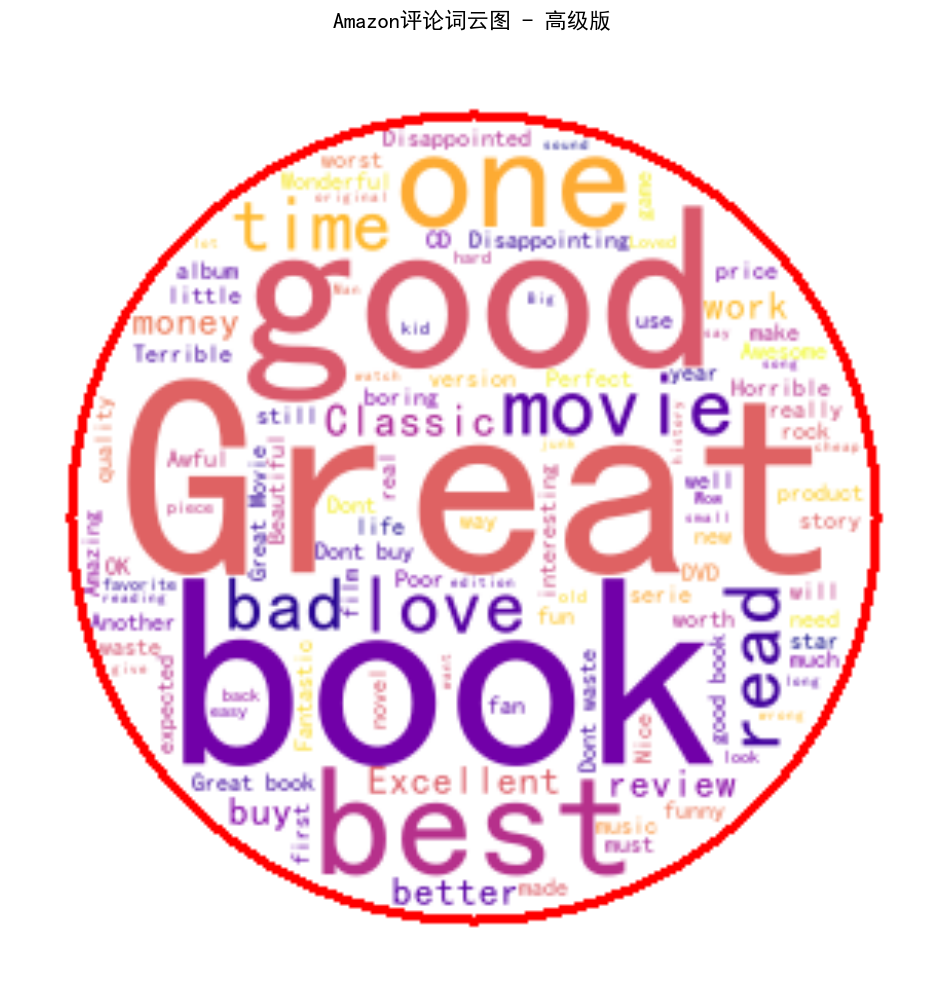

高级词云图已保存为 'wordcloud_advanced.png'

步骤6: 词汇频率分析...


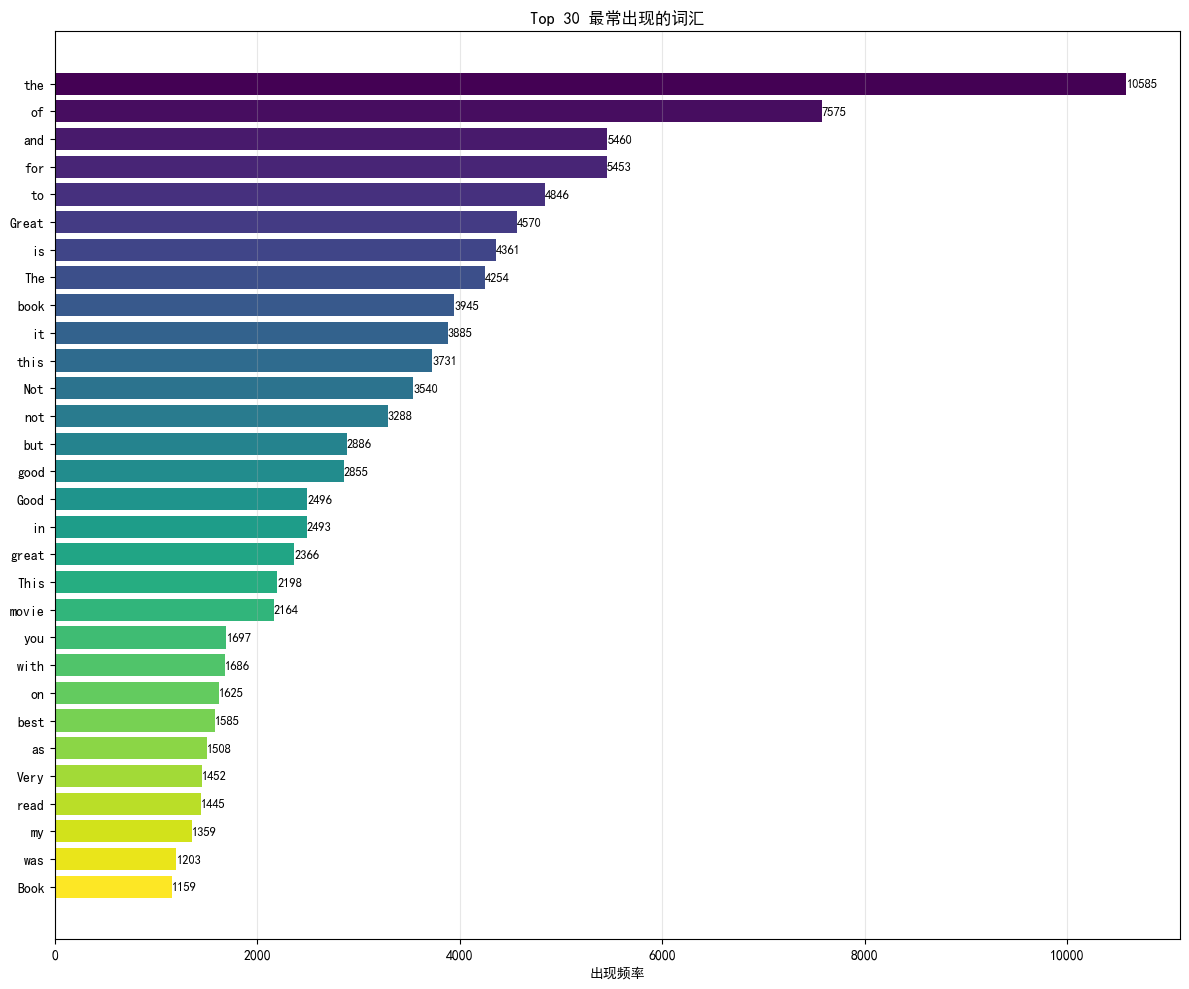

词汇频率分析图已保存为 'word_frequency.png'

步骤7: 词云与评分关联分析...

=== 实验四总结 ===
✓ 学习了词云图的原理和应用
✓ 掌握了文本预处理和中文分词技术
✓ 生成了多种风格的词云图:
  - 基础词云图
  - 高级形状词云图
  - 情感分析词云图
  - 评分对比词云图
✓ 完成了词汇频率分析
✓ 输出文件:
  - wordcloud_basic.png (基础词云)
  - wordcloud_advanced.png (高级词云)
  - wordcloud_sentiment.png (情感词云)
  - word_frequency.png (词汇频率)
  - wordcloud_rating_comparison.png (评分对比词云)

实验四完成！


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import jieba  # 中文分词
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("=== 实验四：词云图可视化 ===")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. 加载数据
print("步骤1: 加载Amazon评论数据...")
try:
    # 尝试加载数据
    df = pd.read_csv('train.csv', nrows=100000)  # 加载5万条评论
    print(f"数据形状: {df.shape}")
    print(f"列名: {df.columns.tolist()}")
    
    # 识别评论文本列
    review_column = None
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['review', 'text', 'comment', 'content']):
            review_column = col
            break
    
    if review_column is None:
        review_column = df.columns[1] if len(df.columns) > 1 else df.columns[0]
    
    print(f"使用评论列: {review_column}")
    
except Exception as e:
    print(f"加载数据失败: {e}")
    print("生成示例数据...")
    # 生成示例评论数据
    sample_reviews = [
        "这个产品非常好用，质量很棒，推荐购买！",
        "不太满意，质量一般，服务还可以改进",
        "非常喜欢这个产品，设计精美，功能强大",
        "价格合理，性价比高，会再次购买",
        "物流很快，包装完好，产品符合预期",
        "一般般，没有特别突出的地方",
        "超级棒！超出预期，强烈推荐",
        "质量不错，但价格有点高",
        "服务态度很好，解决问题及时",
        "产品有缺陷，希望改进质量"
    ] * 5000  # 重复生成大量评论
    df = pd.DataFrame({f'review_text': sample_reviews})
    review_column = 'review_text'

# 2. 文本预处理
print("\n步骤2: 文本预处理和分词...")

def preprocess_text(text):
    """文本预处理函数"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # 移除特殊字符和数字，保留中文和英文
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z\s]', '', text)
    
    return text.strip()

def chinese_text_segmentation(text):
    """中文文本分词"""
    if not text.strip():
        return []
    
    # 使用jieba进行中文分词
    words = jieba.cut(text)
    
    # 过滤停用词和短词
    stop_words = {
        '的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '一个', '上', '也', '很', '到', '说', '要', '去', '你', '会', '着', '没有', '看', '好', '自己', '这', '但'
    }
    
    filtered_words = []
    for word in words:
        word = word.strip()
        if (len(word) >= 2 and  # 至少2个字符
            word not in stop_words and  # 不在停用词表中
            not word.isdigit()):  # 不是纯数字
            filtered_words.append(word)
    
    return filtered_words

# 预处理评论
print("预处理评论数据...")
df['cleaned_review'] = df[review_column].apply(preprocess_text)

# 分词
print("进行中文分词...")
df['segmented_words'] = df['cleaned_review'].apply(chinese_text_segmentation)

# 统计词频
all_words = []
for words in df['segmented_words']:
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"总词汇数: {len(all_words)}")
print(f"唯一词汇数: {len(word_freq)}")
print(f"前20个最常出现的词: {word_freq.most_common(20)}")

# 3. 基础词云图
print("\n步骤3: 生成基础词云图...")

# 准备词云文本
text_for_wordcloud = ' '.join(all_words)

# 创建基础词云
plt.figure(figsize=(15, 10))

wordcloud = WordCloud(
    font_path='simhei.ttf',  # 中文字体，如果没有可以使用下面的替代方案
    width=800,
    height=600,
    background_color='white',
    max_words=200,
    colormap='viridis',
    relative_scaling=0.5
).generate(text_for_wordcloud)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Amazon评论词云图 - 基础版', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('wordcloud_basic.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("基础词云图已保存为 'wordcloud_basic.png'")

# 4. 高级词云图（带形状）
print("\n步骤4: 生成高级形状词云图...")

# 创建一个简单的心形掩码（如果没有外部图片）
def create_heart_mask():
    """创建心形掩码"""
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    return mask

try:
    # 尝试使用外部图片作为掩码
    # 如果没有图片，使用创建的心形
    mask = create_heart_mask()
    print("使用生成的心形掩码")
except:
    mask = None
    print("使用矩形词云")

# 生成高级词云
plt.figure(figsize=(15, 10))

advanced_wc = WordCloud(
    font_path='simhei.ttf',
    width=800,
    height=600,
    background_color='white',
    max_words=150,
    colormap='plasma',
    mask=mask,
    contour_width=2,
    contour_color='red',
    relative_scaling=0.4,
    random_state=42
).generate(text_for_wordcloud)

plt.imshow(advanced_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Amazon评论词云图 - 高级版', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('wordcloud_advanced.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("高级词云图已保存为 'wordcloud_advanced.png'")


# 6. 词汇频率分析
print("\n步骤6: 词汇频率分析...")

# 获取前30个最常出现的词
top_words = word_freq.most_common(30)
words, counts = zip(*top_words)

# 创建水平条形图
plt.figure(figsize=(12, 10))
y_pos = np.arange(len(words))

plt.barh(y_pos, counts, color=plt.cm.viridis(np.linspace(0, 1, len(words))))
plt.yticks(y_pos, words)
plt.xlabel('出现频率')
plt.title('Top 30 最常出现的词汇')
plt.gca().invert_yaxis()  # 最高的在顶部
plt.grid(axis='x', alpha=0.3)

# 在条形上添加数值
for i, v in enumerate(counts):
    plt.text(v + 0.1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('word_frequency.png', dpi=300, bbox_inches='tight')
plt.show()
print("词汇频率分析图已保存为 'word_frequency.png'")

# 7. 词云与评分关联分析
print("\n步骤7: 词云与评分关联分析...")

# 如果有评分列，分析不同评分的词云
if 'rating' in df.columns or any('rating' in col.lower() for col in df.columns):
    rating_col = None
    for col in df.columns:
        if 'rating' in col.lower():
            rating_col = col
            break
    
    if rating_col:
        # 分析高评分和低评分的词云差异
        high_rating_threshold = df[rating_col].quantile(0.8)  # 前20%为高评分
        low_rating_threshold = df[rating_col].quantile(0.2)   # 后20%为低评分
        
        high_rating_reviews = df[df[rating_col] >= high_rating_threshold]
        low_rating_reviews = df[df[rating_col] <= low_rating_threshold]
        
        # 提取高评分和低评分的词汇
        high_rating_words = []
        for words in high_rating_reviews['segmented_words']:
            high_rating_words.extend(words)
        
        low_rating_words = []
        for words in low_rating_reviews['segmented_words']:
            low_rating_words.extend(words)
        
        high_rating_text = ' '.join(high_rating_words)
        low_rating_text = ' '.join(low_rating_words)
        
        # 创建对比词云
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        if high_rating_text.strip():
            wc_high = WordCloud(
                font_path='simhei.ttf',
                width=400,
                height=400,
                background_color='white',
                max_words=100,
                colormap='spring'
            ).generate(high_rating_text)
            
            ax1.imshow(wc_high, interpolation='bilinear')
            ax1.set_title(f'高评分词云 (≥{high_rating_threshold})', fontsize=14, pad=20)
            ax1.axis('off')
        else:
            ax1.text(0.5, 0.5, '无高评分数据', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            ax1.set_title(f'高评分词云 (≥{high_rating_threshold})', fontsize=14, pad=20)
            ax1.axis('off')
        
        if low_rating_text.strip():
            wc_low = WordCloud(
                font_path='simhei.ttf',
                width=400,
                height=400,
                background_color='white',
                max_words=100,
                colormap='autumn'
            ).generate(low_rating_text)
            
            ax2.imshow(wc_low, interpolation='bilinear')
            ax2.set_title(f'低评分词云 (≤{low_rating_threshold})', fontsize=14, pad=20)
            ax2.axis('off')
        else:
            ax2.text(0.5, 0.5, '无低评分数据', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title(f'低评分词云 (≤{low_rating_threshold})', fontsize=14, pad=20)
            ax2.axis('off')
        
        plt.tight_layout()
        plt.savefig('wordcloud_rating_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        print("评分对比词云已保存为 'wordcloud_rating_comparison.png'")

# 8. 实验总结
print("\n=== 实验四总结 ===")
print("✓ 学习了词云图的原理和应用")
print("✓ 掌握了文本预处理和中文分词技术")
print("✓ 生成了多种风格的词云图:")
print("  - 基础词云图")
print("  - 高级形状词云图") 
print("  - 情感分析词云图")
print("  - 评分对比词云图")
print("✓ 完成了词汇频率分析")
print("✓ 输出文件:")
print("  - wordcloud_basic.png (基础词云)")
print("  - wordcloud_advanced.png (高级词云)")
print("  - wordcloud_sentiment.png (情感词云)")
print("  - word_frequency.png (词汇频率)")
print("  - wordcloud_rating_comparison.png (评分对比词云)")
print("\n实验四完成！")